In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import string
import re
import matplotlib.pyplot as plt

In [32]:
# Check if .gitignore exists and handle *.npy exception
gitignore_path = "../.gitignore"
if os.path.exists(gitignore_path):
    # Read current content
    with open(gitignore_path, "r") as f:
        content = f.read()
    
    # Only append if *.npy is not already in the file
    if "*.npy" not in content:
        with open(gitignore_path, "a") as f:
            f.write("\n*.npy")  # Add newline before appending
else:
    # Create new .gitignore if it doesn't exist
    with open(gitignore_path, "w") as f:
        f.write("*.npy")


DATA_DIR = input("Enter the name of the directory")
if not os.path.exists(DATA_DIR):
    print(f"Error: The directory {DATA_DIR} does not exist.")


In [34]:
import numpy as np
import torch
import os
import torch.nn.functional as F  # Import F for padding

# Path to the directory containing the saved NumPy arrays
NUMPY_DIR = DATA_DIR + "/numpy_arrays"
BASE_SIZE = torch.Size([1, 80, 300])

# Function to load all spectrograms from the directory
def load_spectrograms_from_directory(directory):
    spectrograms = []
    keys = []
    widths = []
    filenames = os.listdir(directory)

    # Loop through each file in the directory
    for filename in filenames:
        if filename.endswith('.npy'):
            file_path = os.path.join(directory, filename)

            # Load the NumPy array from file
            spectrogram = np.load(file_path)

            widths.append(spectrogram.shape[1])

            try: 
                key = re.search(r"keystroke_\d+_([A-Za-z])\.npy", filename).group(1)
            except AttributeError:
                print(f"Error: Could not extract key from filename: {filename}. Make sure it is a valid key (aA-zZ)")
                continue
            # Convert the spectrogram to a PyTorch tensor
            # Adding a channel dimension (1, height, width) for CNN input
            spectrogram_tensor = torch.tensor(spectrogram).unsqueeze(0).float()  # Shape: (1, n_freq_bins, n_time_bins)

            if(spectrogram_tensor.shape != BASE_SIZE):
                spectrogram_tensor = pad_tensor(spectrogram_tensor, BASE_SIZE[2])
                if(spectrogram_tensor.shape != BASE_SIZE):
                    print(f"Warning: Spectrogram tensor shape {spectrogram_tensor.shape} does not match the expected size {BASE_SIZE}")

            # next, add the tensor to a list
            spectrograms.append(spectrogram_tensor)
            keys.append(key)

    return spectrograms, keys, max(widths)


spectrogram_tensors, keys, max_width = load_spectrograms_from_directory(NUMPY_DIR)

assert len(spectrogram_tensors) == len(keys), "The number of spectrograms and keys do not match!"


## Need to pad the spectrograms to the same width

# Padding function
def pad_tensor(tensor, max_height):
    # Calculate padding size (for the width dimension)
    current_width = tensor.shape[2]  # Index 2 is for the time dimension (width)
    if current_width < max_height:
        padding = max_height - current_width
        # Pad with zeros on the right (width dimension)
        return F.pad(tensor, (0, padding))  # Pad (left, right)
    if current_width > max_height:
        print("Warning: Tensor overshoots the limit height")
        return tensor[:, :, :max_height]
    # the tensor overshoots the limit so we consider it an outlier
    return tensor

# Apply padding to all spectrograms
for i in range(len(spectrogram_tensors)):
        if (padded := pad_tensor(spectrogram_tensors[i], 300)) is not None:
            spectrogram_tensors[i] = padded


# Verify padding
for i, spectrogram in enumerate(spectrogram_tensors):
    #print(f"Shape of spectrogram {i}: {spectrogram.shape}")
    pass

alphabet = "abcdefghijklmnopqrstuvwxyz"
char2idx = {char: idx for idx, char in enumerate(alphabet)}
label_indices = [char2idx[char] for char in keys]
label_tensor = torch.tensor(label_indices, dtype=torch.long)


Error: Could not extract key from filename: keystroke_1_Key.cmd.npy. Make sure it is a valid key (aA-zZ)
Error: Could not extract key from filename: keystroke_390_Key.esc.npy. Make sure it is a valid key (aA-zZ)


In [35]:
class KeystrokeDataset(Dataset):
    def __init__(self, spectrograms_tensors, labels):
        self.spectrograms = spectrograms_tensors
        self.labels = labels

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

### Optional : save the tensors in a file for storing
* the following cell is optional and can be skipped

In [47]:
data_to_save = {
    'tensors': spectrogram_tensors,
    'labels': label_tensor,
}

# Save to a file
torch.save(data_to_save, 'keystroke_data.pt')

# export the data to GPU server
from subprocess import run
run(['sshpass', '-p', 'test', 'scp', '-P', '5002', '-o', 'StrictHostKeyChecking=no', '-o', 'UserKnownHostsFile=/dev/null', 'keystroke_data.pt', 'test@oscartesniere.com:/home/test/'])  




In [36]:
import os
try:
    os.chdir('/home/test')
    loaded_data = torch.load('keystroke_data.pt')
    # Extract the tensors and labels
    spectrogram_tensors = loaded_data['tensors']
    label_tensor = loaded_data['labels']
except:
    print("Could not change directory to /home/test")
    print("If you intended to run the code locally, you can skip this message")
    

train_dataset = KeystrokeDataset(spectrogram_tensors,label_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


Could not change directory to /home/test
If you intended to run the code locally, you can skip this message


In [2]:
class KeystrokeCNN(nn.Module):
    def __init__(self,input_height=80, input_width=300, num_classes=26):
        super(KeystrokeCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (1, H, W) -> (32, H, W)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (32, H, W) -> (64, H, W)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (64, H, W) -> (128, H, W)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Reduces dimensions by half (H/2, W/2)

        # Calculate the final feature map size dynamically
        self._to_linear = self._get_conv_output_size(input_height, input_width)

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)  
        self.fc2 = nn.Linear(512, num_classes)  # 26 output classes (A-Z)
        #list(string.ascii_lowercase) for generating the output classes

    def _get_conv_output_size(self, height, width):
        """Pass a dummy tensor to determine final feature map size after convolutions"""
        x = torch.zeros(1, 1, height, width)  # Batch size = 1, 1 channel, (H, W)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x.numel()  # Flattened size
    
    def forward(self, x):
        #print("Input shape:", x.shape)
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
       # print("After conv1+pool:", x.shape)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
       # print("After conv2+pool:", x.shape)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
       # print("After conv3+pool:", x.shape)
        
        x = x.view(x.size(0), -1)
        #print("After flattening:", x.shape)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = KeystrokeCNN()




In [38]:
# Loss function and optimizer
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

keyboard_names = ('dell', 'macbook') # enter any new keyboard here for identification


Epoch 1 average loss: 3.266
Epoch 2 average loss: 3.136
Epoch 3 average loss: 3.157
Epoch 4 average loss: 3.140
Epoch 5 average loss: 3.179
Epoch 6 average loss: 3.114
Epoch 7 average loss: 3.104
Epoch 8 average loss: 3.074
Epoch 9 average loss: 3.101
Epoch 10 average loss: 3.077
Epoch 11 average loss: 3.123
Epoch 12 average loss: 3.147
Epoch 13 average loss: 3.060
Epoch 14 average loss: 3.035
Epoch 15 average loss: 3.051
Epoch 16 average loss: 3.072
Epoch 17 average loss: 2.973
Epoch 18 average loss: 3.004
Epoch 19 average loss: 2.933
Epoch 20 average loss: 2.831
Epoch 21 average loss: 2.843
Epoch 22 average loss: 2.751
Epoch 23 average loss: 2.754
Epoch 24 average loss: 2.790
Epoch 25 average loss: 2.647
Epoch 26 average loss: 2.712
Epoch 27 average loss: 2.613
Epoch 28 average loss: 2.581
Epoch 29 average loss: 2.480
Epoch 30 average loss: 2.524
Epoch 31 average loss: 2.314
Epoch 32 average loss: 2.510
Epoch 33 average loss: 2.293
Epoch 34 average loss: 2.214
Epoch 35 average loss: 

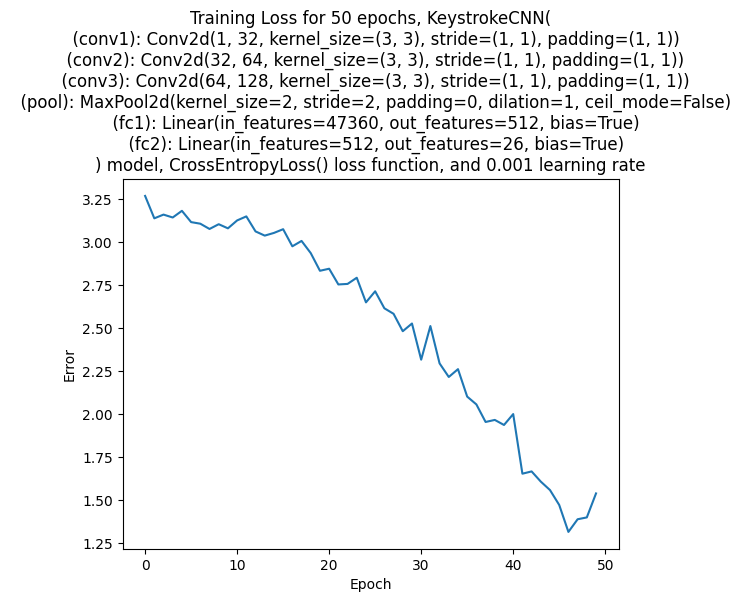

In [39]:
# Function to train the model
from datetime import datetime

def train(model, train_loader, criterion, optimizer, epochs=5,keyboard_name=''):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        epoch_losses = []
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            
            try:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                epoch_losses.append(loss.item())
                
                if i % 10 == 9:  # Print every 10 batches
                    print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}")
                    running_loss = 0.0
                    
            except Exception as e:
                print("Input tensors may not be of the right shape", e)
                raise e
        
        # Store average loss for this epoch
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_epoch_loss)
        print(f"Epoch {epoch + 1} average loss: {avg_epoch_loss:.3f}")
        """ Save model after each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }, f"{save_path}_epoch_{epoch+1}.pt")
        """
    filename  = datetime.now().strftime("%Y%m%d_%H%M%S") + '_' + keyboard_name + '_keystroke_model.pt'
    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': losses[-1],
    }, filename)
    
    return losses, filename

# Training call
epochs = 50
losses, filename = train(model, train_loader, criterion, optimizer, epochs,keyboard_name=keyboard_names[0])

# Plot training loss
plt.plot(range(epochs), losses)
plt.title(f'Training Loss for {epochs} epochs, {model} model, {criterion} loss function, and {lr} learning rate')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()


In [12]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime

# Define character mapping (should match what you used in training)
letters = "abcdefghijklmnopqrstuvwxyz"
idx2char = {i: c for i, c in enumerate(letters)}

for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

def predict(model, spectrogram_tensor):
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():  # No need to compute gradients
        spectrogram_tensor = spectrogram_tensor.unsqueeze(0)  # Add batch dimension (1, 1, 129, 300)
        output = model(spectrogram_tensor)  # Forward pass
        probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities
        predicted_idx = torch.argmax(probabilities, dim=1).item()  # Get class index
        predicted_letter = idx2char[predicted_idx]  # Convert index to letter
        
    return predicted_letter


def crop_spectrogram(tensor, target_width=300):
    return tensor[:, :, :target_width] 


spectrogram_tensors, keys, max_width = load_spectrograms_from_directory(NUMPY_DIR)
# torch.Size([1, 1, 129, *])
TP = 0
FP = 0
TN = 0
FN = 0

y_hat = []
for i in range(len(spectrogram_tensors)):
    test_tensor = pad_tensor(spectrogram_tensors[i], max_height=300) 
    print(test_tensor.shape)
    predicted_letter = predict(model, test_tensor)
    y_hat.append(predicted_letter)
    #print(f"Predicted letter: {predicted_letter}")
    #print("actual letter:", keys[i])
    if predicted_letter == keys[i]:
        TP += 1
    else:
        FP += 1
    if predicted_letter != keys[i]:
        TN += 1
    else:
        FN += 1

print("accuracy:", (TP + TN) / (TP + TN + FP + FN))
print("precision:", TP / (TP + FP))
print("recall:", TP / (TP + FN))
print("F1 score:", 2 * TP / (2 * TP + FP + FN))

cm= confusion_matrix(y_hat, keys)
plt.figure(figsize=(12, 8))
classes = list(letters) 
sns.heatmap(cm, 
            annot=True,  # Show numbers in each cell
            fmt='d',     # Format as integers
            cmap='Blues', # Color scheme
            xticklabels=classes,  # Labels on x-axis: ['a', 'b', 'c', ..., 'z']
            yticklabels=classes) 
plt.title(f'Confusion Matrix for {epochs} epochs, {model} model, {criterion} loss function, and {lr} learning rate')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

plt.savefig(f'confusion_matrix_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()



conv1.weight: torch.Size([32, 1, 3, 3])
conv1.bias: torch.Size([32])
conv2.weight: torch.Size([64, 32, 3, 3])
conv2.bias: torch.Size([64])
conv3.weight: torch.Size([128, 64, 3, 3])
conv3.bias: torch.Size([128])
fc1.weight: torch.Size([512, 47360])
fc1.bias: torch.Size([512])
fc2.weight: torch.Size([26, 512])
fc2.bias: torch.Size([26])


NameError: name 'load_spectrograms_from_directory' is not defined

Left for implementation : adding a live prediction 


In [ ]:

import numpy as np
import sounddevice as sd
import scipy.signal as signal
import torch
from scipy.ndimage import zoom
import time
from queue import Queue
import threading
import librosa
from scipy.signal import find_peaks
import time

letters = "abcdefghijklmnopqrstuvwxyz"
idx2char = {i: c for i, c in enumerate(letters)}

class LiveKeystrokeDetector:
    def __init__(self, model, sample_rate=44100, window_size=0.2, threshold=0.9999999):
        self.model = model
        self.sample_rate = sample_rate
        self.window_size = window_size
        self.threshold = threshold
        self.window_samples = int(window_size * sample_rate)
        self.audio_buffer = np.zeros(self.window_samples)
        self.prediction_queue = Queue()
        self.is_recording = False
        self.debounce_time = time.time()
        
    def audio_callback(self, indata, frames, time_info, status):
        """Callback function for audio streaming"""
        if status:
            print(f"Audio callback status: {status}")
            
        # Update buffer with new audio data
        self.audio_buffer = np.roll(self.audio_buffer, -frames)
        self.audio_buffer[-frames:] = indata.flatten()
        

        mel_spect = librosa.feature.melspectrogram(
            y=self.audio_buffer,
            sr=self.sample_rate,
            n_mels=80,           # Reduced from 128 - still detailed enough
            n_fft=2048,          # Keep this - good balance
            hop_length=512,      # Changed from 1024 for better temporal resolution
            window='hann',       # Keep this - good choice
            power=2.0            # Keep this - standard choice
        )

        # Convert to log scale (dB)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

        # Normalize to 0-1 range
        mel_spect_norm = (mel_spect_db - mel_spect_db.min()) / (mel_spect_db.max() - mel_spect_db.min())

        # Convert to tensor
        spectrogram_tensor = torch.FloatTensor(mel_spect_norm)
        
        # Pad or truncate to 300 in the last dimension
        current_length = spectrogram_tensor.shape[-1]
        if current_length < 300:
            # Pad to 300
            padding = (0, 300 - current_length)
            spectrogram_tensor = F.pad(spectrogram_tensor, padding, mode='constant', value=0)
        elif current_length > 300:
            # Center crop to 300
            start = (current_length - 300) // 2
            spectrogram_tensor = spectrogram_tensor[..., start:start+300]
        
        # Get the energy over time
        energy = np.mean(mel_spect, axis=0)
        
        # Find peaks with minimum height and distance
        peaks, _ = find_peaks(energy, 
                            height=0.5,          # Minimum height
                            distance=20,         # Minimum samples between peaks
                            prominence=0.3)      # Minimum prominence of peaks
        
        if len(peaks) > 0 and time.time() - self.debounce_time > 1:
            print("Keystroke detected")
            # Make prediction
            with torch.no_grad():
                spectrogram_tensor = spectrogram_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions (1, 1, 80, 300)
                output = model(spectrogram_tensor)  # Forward pass
                probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities
                predictions = sorted([(idx2char[letter],prob.item()) for letter, prob in enumerate(probabilities[0])], key=lambda x: x[1], reverse=True)
                print(predictions[:5])
                predicted_idx = torch.argmax(probabilities, dim=1).item()  # Get class index
                predicted_letter = idx2char[predicted_idx]  # Convert index to letter
                self.prediction_queue.put(predicted_letter)

            print("------------------------------------------")
            # add a delay to prevent multiple detections for the same keystroke
            self.debounce_time = time.time()

    
    def start_recording(self):
        """Start recording and processing audio"""
        self.is_recording = True
        print("Starting live keystroke detection...")
        
        try:
            with sd.InputStream(samplerate=self.sample_rate, 
                              channels=1, 
                              callback=self.audio_callback):
                while self.is_recording:
                    # Process predictions from queue
                    try:
                        prediction = self.prediction_queue.get_nowait()
                        print(f"Predicted key: {prediction}")
                    except:
                        pass
                    time.sleep(0.01)  # Prevent high CPU usage
                    
        except KeyboardInterrupt:
            print("\nStopping recording...")
            self.is_recording = False
    
    def stop_recording(self):
        """Stop recording"""
        self.is_recording = False

    

def main():
    # Load your trained model
    try: 
        model = KeystrokeCNN()
        checkpoint = torch.load(filename)  # Replace with your model path
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded successfully")
    except:
        try: 
            print("Error: Could not load model")
            print("trying to load model from file")
            filename = "/home/zachary-chuang/mcgill/mais202/MAIS202-FinalProject/test/20250324_163048_dell_keystroke_model.pt" #input("enter filename of saved model")
            model = KeystrokeCNN()
            checkpoint = torch.load(filename)  # Replace with your model path
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Model loaded successfully")
        except FileNotFoundError:
            print("Error: Could not load model")
            print("Please check the model file name and try again")
            return
    model.eval()  # Set to evaluation mode
    
    # Create detector instance
    detector = LiveKeystrokeDetector(model)
    
    try:
        # Start recording
        detector.start_recording()
    except KeyboardInterrupt:
        print("\nStopping...")
        detector.stop_recording()

if __name__ == "__main__":
    main()

Error: Could not load model
trying to load model from file


RuntimeError: Error(s) in loading state_dict for KeystrokeCNN:
	size mismatch for fc1.weight: copying a param with shape torch.Size([512, 75776]) from checkpoint, the shape in current model is torch.Size([512, 47360]).